<a href="https://colab.research.google.com/github/nv-hiep/object_detection/blob/main/Step3_Prepare_data_for_Multi_class_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-class object detection and bounding box regression with Keras, TensorFlow, and Deep Learning

To build a Multi-class object detector with Keras and TensorFlow:

1. Use VGG16 model and remove the fully-connected (FC) layer head.

2. Construct a new FC layer head with two branches:
 

*   Branch 1: A series of FC layers that end with a layer with (1) four neurons, corresponding to the top-left and bottom-right (x, y)-coordinates of the predicted bounding box and (2) a sigmoid activation function, such that the output of each four neurons lies in the range [0, 1]. This branch is responsible for bounding box predictions.
*   Branch 2: Another series of FC layers, but this one with a softmax classifier at the end. This branch is in charge of making class label predictions.

3. Place the new FC layer head (with the two branches) on top of the VGG16 base.
4. Fine-tune the entire network for end-to-end object detection

A multi-class object detector needs a fully-connected layer head with two branches:

1. A regression layer set, just like in the single-class object detection case
2. An additional layer set, this one with a softmax classifier used to predict class labels

Used together, a single forward pass of our multi-class object detector will result in:

1. The predicted bounding box coordinates of the object in the image.

2. The predicted class label of the object in the image.

# Connect and authorize google drive with google colab:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/object_detection
!ls

/content/gdrive/My Drive/Colab Notebooks/object_detection
 data
 logo.png
 model
 plots
'Step1_Bounding box with OpenCV.ipynb'
'step2_Bounding box regression with Keras, TensorFlow, and Deep Learning.ipynb'
'Step3 Multi-class object detection and bounding box regression with Keras, TensorFlow, and Deep Learning.ipynb'
'Step3 Prepare data for Multi-class object detection.ipynb'
 test


# Libraries

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import os
import glob
import time
import csv
import cv2

import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.patches as patches

from PIL import Image
from scipy.io import loadmat


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [ ]:
from keras.applications import VGG16
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

from google.colab.patches import cv2_imshow

#1. Caltech 101 dataset

## 1.1 Data directories

In [ ]:
# APP_PATH = !pwd
APP_PATH  = '/content/gdrive/My Drive/Colab Notebooks/object_detection'
DAT_DIR   = os.path.join(APP_PATH, 'data')
PREP_DIR  = os.path.join(DAT_DIR, 'prep')
DATA_PATH = os.path.join(DAT_DIR, '101_ObjectCategories')
ANN_PATH  = os.path.join(DAT_DIR, 'Annotations') 

print('Project path: ', APP_PATH)
print('Data path: ', DATA_PATH)
print('Annotation path: ', ANN_PATH)

Project path:  /content/gdrive/My Drive/Colab Notebooks/object_detection
Data path:  /content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories
Annotation path:  /content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations


In [ ]:
if not os.path.exists(PREP_DIR):
  os.makedirs(PREP_DIR)

In [ ]:
MODEL_PATH = os.path.join(APP_PATH, 'model')
PLOT_PATH = os.path.join(APP_PATH, 'plots')
TEST_PATH = os.path.join(APP_PATH, 'test')

print('Model path: ', MODEL_PATH)
print('Plot path: ', PLOT_PATH)
print('Test path: ', TEST_PATH)

if not os.path.exists(MODEL_PATH):
  os.makedirs(MODEL_PATH)

if not os.path.exists(PLOT_PATH):
  os.makedirs(PLOT_PATH)

if not os.path.exists(TEST_PATH):
  os.makedirs(TEST_PATH)

Model path:  /content/gdrive/My Drive/Colab Notebooks/object_detection/model
Plot path:  /content/gdrive/My Drive/Colab Notebooks/object_detection/plots
Test path:  /content/gdrive/My Drive/Colab Notebooks/object_detection/test


##1.2 All labels and annotations

In [ ]:
# subdirectories in 101_ObjectCategories
dirs   = glob.glob( os.path.join(DATA_PATH, '*') )
labels = [x.split('/')[-1] for x in dirs]
print('Number of labels: ', len(labels))
print('Some examples: ', labels)

Number of labels:  102
Some examples:  ['bonsai', 'anchor', 'barrel', 'beaver', 'bass', 'BACKGROUND_Google', 'airplanes', 'ant', 'accordion', 'binocular', 'brontosaurus', 'butterfly', 'brain', 'cellphone', 'chair', 'car_side', 'cannon', 'ceiling_fan', 'buddha', 'camera', 'dollar_bill', 'dalmatian', 'chandelier', 'cup', 'cougar_body', 'crocodile', 'crab', 'cougar_face', 'crayfish', 'crocodile_head', 'Faces_easy', 'ferry', 'dolphin', 'Faces', 'euphonium', 'emu', 'electric_guitar', 'elephant', 'ewer', 'dragonfly', 'garfield', 'headphone', 'grand_piano', 'helicopter', 'flamingo', 'gramophone', 'hedgehog', 'hawksbill', 'flamingo_head', 'gerenuk', 'ibis', 'joshua_tree', 'lobster', 'kangaroo', 'inline_skate', 'lamp', 'ketch', 'llama', 'Leopards', 'laptop', 'Motorbikes', 'metronome', 'okapi', 'nautilus', 'mandolin', 'mayfly', 'lotus', 'octopus', 'menorah', 'minaret', 'saxophone', 'pagoda', 'panda', 'pizza', 'rhino', 'pigeon', 'rooster', 'revolver', 'pyramid', 'platypus', 'schooner', 'stop_sign

In [ ]:
# subdirectories in Annotations
dirs = glob.glob( os.path.join(ANN_PATH, '*') )
anns = [x.split('/')[-1] for x in dirs]
print('Number of Annotations: ', len(anns))
print('Some examples: ', anns)

Number of Annotations:  106
Some examples:  ['progress.mat', 'README', 'README~', 'FeatureDetectionQuality.mat', 'check_progress.mat', 'Airplanes_Side_2', 'ant', 'brain', 'anchor', 'beaver', 'bass', 'binocular', 'bonsai', 'accordion', 'barrel', 'chair', 'butterfly', 'cellphone', 'camera', 'buddha', 'car_side', 'ceiling_fan', 'chandelier', 'cannon', 'brontosaurus', 'cougar_face', 'cougar_body', 'dolphin', 'crocodile', 'dalmatian', 'crab', 'cup', 'dollar_bill', 'crocodile_head', 'crayfish', 'flamingo', 'electric_guitar', 'Faces_2', 'ferry', 'dragonfly', 'ewer', 'Faces_3', 'elephant', 'euphonium', 'emu', 'helicopter', 'gerenuk', 'headphone', 'flamingo_head', 'gramophone', 'hawksbill', 'grand_piano', 'ibis', 'garfield', 'hedgehog', 'llama', 'joshua_tree', 'ketch', 'lotus', 'inline_skate', 'lobster', 'lamp', 'Leopards', 'laptop', 'kangaroo', 'octopus', 'mayfly', 'minaret', 'Motorbikes_16', 'pagoda', 'metronome', 'nautilus', 'okapi', 'menorah', 'mandolin', 'rhino', 'pigeon', 'pizza', 'schoon

#2. Label: Motorbikes

In [ ]:
mylabel_img = 'Motorbikes'
mylabel_ann = 'Motorbikes_16'

img_samples = glob.glob( os.path.join(DATA_PATH, mylabel_img, '*') )
print('Number of sample images: ', len(img_samples))
print(img_samples[:5])

ann_samples = glob.glob( os.path.join(ANN_PATH, mylabel_ann, '*') )
print('Number of sample annotations: ', len(ann_samples))
print(ann_samples[:5])

Number of sample images:  798
['/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/Motorbikes/image_0026.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/Motorbikes/image_0020.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/Motorbikes/image_0024.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/Motorbikes/image_0031.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/Motorbikes/image_0010.jpg']
Number of sample annotations:  798
['/content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations/Motorbikes_16/annotation_0093.mat', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations/Motorbikes_16/annotation_0061.mat', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations/Motorbikes_16/annotation_0039.mat', '/content/gdrive/My Drive/Colab 

Plot some samples

Image shape: (180, 275, 3)
Image shape: (159, 263, 3)
Image shape: (153, 263, 3)
Image shape: (150, 265, 3)


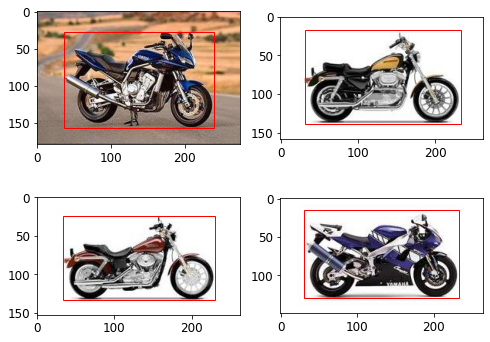

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8,6))
axs = axs.flatten()

for i in range(4):
  ximg   = Image.open(img_samples[i])
  img_id = img_samples[i].split('/')[-1].replace('.jpg', '').replace('image_', '')
  print(f'Image shape: {np.array(ximg).shape}')
  axs[i].imshow(ximg)

  ann_file     = os.path.join(ANN_PATH, mylabel_ann, 'annotation_' + img_id + '.mat')
  (y, h, x, w) = loadmat(ann_file)['box_coord'][0]

  rect = patches.Rectangle( (x, y), w-x, h-y, linewidth=1, edgecolor='r', facecolor='none')  
  axs[i].add_patch(rect)

plt.show()

Write image+annottion infor to CSV file

In [ ]:
print(f'Number of samples: {len(img_samples)}')

Number of samples: 798


In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/object_detection
!pwd

/content/gdrive/My Drive/Colab Notebooks/object_detection
/content/gdrive/My Drive/Colab Notebooks/object_detection


In [ ]:
def write_to_csv(img_samples, csv_file):
  '''
  Write to a csv file
  '''
  csv_rowlist = [ ['class', 'img_file', 'annotation_file', 'ID', 'shapes', 'height', 'width', 'x_start', 'x_end', 'y_start', 'y_end', 'targets'] ]
  for i in range( len(img_samples) ):
    ximg     = Image.open(img_samples[i])
    img_id   = img_samples[i].split('/')[-1].replace('.jpg', '').replace('image_', '')
    
    ann_file = os.path.join(ANN_PATH, mylabel_ann, 'annotation_' + img_id + '.mat')
    (y_start, y_end, x_start, x_end) = loadmat(ann_file)['box_coord'][0]

    shapes  = np.array(ximg).shape
    targets = [np.round(x_start/float(shapes[1]), 3), np.round(x_end/float(shapes[1]), 3), np.round(y_start/float(shapes[0]), 3), np.round(y_end/float(shapes[0]), 3)]

    row_ = [mylabel_img.lower(), img_samples[i].split('/')[-1], 'annotation_' + img_id + '.mat', '_' + img_id,
            shapes, float(shapes[0]), float(shapes[1]), float(x_start), float(x_end), float(y_start), float(y_end), targets]
    # print( row_ )
    csv_rowlist.append( row_ )

  print( len(csv_rowlist) )
  with open(csv_file, 'w') as f:
    writer = csv.writer(f)
    writer.writerows(csv_rowlist)

In [ ]:
csv_file = 'data_' + mylabel_img + '.csv'
csv_file = os.path.join(PREP_DIR, csv_file)
print(csv_file)
if not os.path.exists( csv_file ):
  write_to_csv(img_samples, csv_file)

/content/gdrive/My Drive/Colab Notebooks/object_detection/data/prep/data_Motorbikes.csv


Read infor from CSV file

In [ ]:
df = pd.read_csv(csv_file)

In [ ]:
df.head()

,class,img_file,annotation_file,ID,shapes,height,width,x_start,x_end,y_start,y_end,targets
0,motorbikes,image_0026.jpg,annotation_0026.mat,_0026,"(180, 275, 3)",180.0,275.0,36.0,240.0,27.0,158.0,"[0.131, 0.873, 0.15, 0.878]"
1,motorbikes,image_0020.jpg,annotation_0020.mat,_0020,"(159, 263, 3)",159.0,263.0,31.0,234.0,17.0,139.0,"[0.118, 0.89, 0.107, 0.874]"
2,motorbikes,image_0024.jpg,annotation_0024.mat,_0024,"(153, 263, 3)",153.0,263.0,33.0,230.0,25.0,133.0,"[0.125, 0.875, 0.163, 0.869]"
3,motorbikes,image_0031.jpg,annotation_0031.mat,_0031,"(150, 265, 3)",150.0,265.0,30.0,233.0,15.0,129.0,"[0.113, 0.879, 0.1, 0.86]"
4,motorbikes,image_0010.jpg,annotation_0010.mat,_0010,"(148, 263, 3)",148.0,263.0,32.0,233.0,18.0,127.0,"[0.122, 0.886, 0.122, 0.858]"


In [ ]:
df.dtypes

class               object
img_file            object
annotation_file     object
ID                  object
shapes              object
height             float64
width              float64
x_start            float64
x_end              float64
y_start            float64
y_end              float64
targets             object
dtype: object

In [ ]:
df['targets'] = df['targets'].str.strip('[]').str.split(',').apply(lambda x: [float(i) for i in x])

In [ ]:
targets   = np.array( [x for x in df.targets], dtype='float32')
filenames = np.array( [x for x in df.img_file] )

In [ ]:
print('targets.shape: ', targets.shape)
targets[:3]

targets.shape:  (798, 4)


array([[0.131, 0.873, 0.15 , 0.878],
       [0.118, 0.89 , 0.107, 0.874],
       [0.125, 0.875, 0.163, 0.869]], dtype=float32)

In [ ]:
print('filenames.shape: ', filenames.shape)
filenames[:3]

filenames.shape:  (798,)


array(['image_0026.jpg', 'image_0020.jpg', 'image_0024.jpg'], dtype='<U14')

In [ ]:
# Read images to X
X = []
for xfile in filenames:
  ximg = load_img( os.path.join(DATA_PATH, mylabel_img, xfile), target_size=(224, 224) ) # For the input-size of VGG16
  ximg = img_to_array(ximg)

  X.append(ximg)

In [ ]:
print('Class: ', mylabel_img)
print('Number of images: ', len(X))
print('Shape of a sample image: ', X[0].shape)

Class:  Motorbikes
Number of images:  798
Shape of a sample image:  (224, 224, 3)


In [ ]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(X, dtype='float32')

In [ ]:
data.shape

(798, 224, 224, 3)

In [ ]:
# save to npy file
npy_file = 'data_' + mylabel_img + '.npy'
npy_file = os.path.join(PREP_DIR, npy_file)
np.save(npy_file, data)

#3. Label: Airplanes

In [ ]:
mylabel_img = 'airplanes'
mylabel_ann = 'Airplanes_Side_2'

img_samples = glob.glob( os.path.join(DATA_PATH, mylabel_img, '*') )
print('Number of sample images: ', len(img_samples))
print(img_samples[:5])

ann_samples = glob.glob( os.path.join(ANN_PATH, mylabel_ann, '*') )
print('Number of sample annotations: ', len(ann_samples))
print(ann_samples[:5])

Number of sample images:  800
['/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/airplanes/image_0012.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/airplanes/image_0011.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/airplanes/image_0005.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/airplanes/image_0017.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/airplanes/image_0014.jpg']
Number of sample annotations:  800
['/content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations/Airplanes_Side_2/annotation_0001.mat', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations/Airplanes_Side_2/annotation_0649.mat', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations/Airplanes_Side_2/annotation_0245.mat', '/content/gdrive/My Drive/Co

Plot some samples

Image shape: (154, 397, 3)
Image shape: (162, 399, 3)
Image shape: (176, 395, 3)
Image shape: (174, 399, 3)


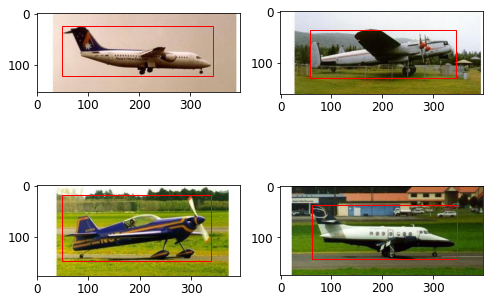

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8,6))
axs = axs.flatten()

for i in range(4):
  ximg   = Image.open(img_samples[i])
  img_id = img_samples[i].split('/')[-1].replace('.jpg', '').replace('image_', '')
  print(f'Image shape: {np.array(ximg).shape}')
  axs[i].imshow(ximg)

  ann_file     = os.path.join(ANN_PATH, mylabel_ann, 'annotation_' + img_id + '.mat')
  (y, h, x, w) = loadmat(ann_file)['box_coord'][0]

  rect = patches.Rectangle( (x, y), w-x, h-y, linewidth=1, edgecolor='r', facecolor='none')  
  axs[i].add_patch(rect)

plt.show()

Write image+annottion infor to CSV file

In [ ]:
print(f'Number of samples: {len(img_samples)}')

Number of samples: 800


In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/object_detection
!pwd

/content/gdrive/My Drive/Colab Notebooks/object_detection
/content/gdrive/My Drive/Colab Notebooks/object_detection


In [ ]:
csv_file = 'data_' + mylabel_img + '.csv'
csv_file = os.path.join(PREP_DIR, csv_file)
print(csv_file)
if not os.path.exists( csv_file ):
  write_to_csv(img_samples, csv_file)

/content/gdrive/My Drive/Colab Notebooks/object_detection/data/prep/data_airplanes.csv


Read infor from CSV file

In [ ]:
df = pd.read_csv(csv_file)

In [ ]:
df.head()

,class,img_file,annotation_file,ID,shapes,height,width,x_start,x_end,y_start,y_end,targets
0,airplanes,image_0012.jpg,annotation_0012.mat,_0012,"(154, 397, 3)",154.0,397.0,49.0,344.0,25.0,122.0,"[0.123, 0.866, 0.162, 0.792]"
1,airplanes,image_0011.jpg,annotation_0011.mat,_0011,"(162, 399, 3)",162.0,399.0,58.0,344.0,35.0,130.0,"[0.145, 0.862, 0.216, 0.802]"
2,airplanes,image_0005.jpg,annotation_0005.mat,_0005,"(176, 395, 3)",176.0,395.0,48.0,339.0,18.0,146.0,"[0.122, 0.858, 0.102, 0.83]"
3,airplanes,image_0017.jpg,annotation_0017.mat,_0017,"(174, 399, 3)",174.0,399.0,62.0,347.0,37.0,143.0,"[0.155, 0.87, 0.213, 0.822]"
4,airplanes,image_0014.jpg,annotation_0014.mat,_0014,"(152, 398, 3)",152.0,398.0,55.0,349.0,37.0,121.0,"[0.138, 0.877, 0.243, 0.796]"


In [ ]:
df.dtypes

class               object
img_file            object
annotation_file     object
ID                  object
shapes              object
height             float64
width              float64
x_start            float64
x_end              float64
y_start            float64
y_end              float64
targets             object
dtype: object

In [ ]:
df['targets'] = df['targets'].str.strip('[]').str.split(',').apply(lambda x: [float(i) for i in x])

In [ ]:
targets   = np.array( [x for x in df.targets], dtype='float32')
filenames = np.array( [x for x in df.img_file] )

In [ ]:
print('targets.shape: ', targets.shape)
targets[:3]

targets.shape:  (800, 4)


array([[0.123, 0.866, 0.162, 0.792],
       [0.145, 0.862, 0.216, 0.802],
       [0.122, 0.858, 0.102, 0.83 ]], dtype=float32)

In [ ]:
print('filenames.shape: ', filenames.shape)
filenames[:3]

filenames.shape:  (800,)


array(['image_0012.jpg', 'image_0011.jpg', 'image_0005.jpg'], dtype='<U14')

In [ ]:
# Read images to X
X = []
for xfile in filenames:
  ximg = load_img( os.path.join(DATA_PATH, mylabel_img, xfile), target_size=(224, 224) ) # For the input-size of VGG16
  ximg = img_to_array(ximg)

  X.append(ximg)

In [ ]:
print('Class: ', mylabel_img)
print('Number of images: ', len(X))
print('Shape of a sample image: ', X[0].shape)

Class:  airplanes
Number of images:  800
Shape of a sample image:  (224, 224, 3)


In [ ]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(X, dtype='float32')

In [ ]:
data.shape

(800, 224, 224, 3)

In [ ]:
# save to npy file
npy_file = 'data_' + mylabel_img + '.npy'
npy_file = os.path.join(PREP_DIR, npy_file)
np.save(npy_file, data)

#4. Label: bonsai

In [ ]:
mylabel_img = 'bonsai'
mylabel_ann = 'bonsai'

img_samples = glob.glob( os.path.join(DATA_PATH, mylabel_img, '*') )
print('Number of sample images: ', len(img_samples))
print(img_samples[:5])

ann_samples = glob.glob( os.path.join(ANN_PATH, mylabel_ann, '*') )
print('Number of sample annotations: ', len(ann_samples))
print(ann_samples[:5])

Number of sample images:  128
['/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/bonsai/image_0007.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/bonsai/image_0043.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/bonsai/image_0037.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/bonsai/image_0041.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/bonsai/image_0028.jpg']
Number of sample annotations:  128
['/content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations/bonsai/annotation_0006.mat', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations/bonsai/annotation_0064.mat', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations/bonsai/annotation_0106.mat', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotatio

Plot some samples

Image shape: (164, 300, 3)
Image shape: (227, 300, 3)
Image shape: (300, 297, 3)
Image shape: (279, 300, 3)


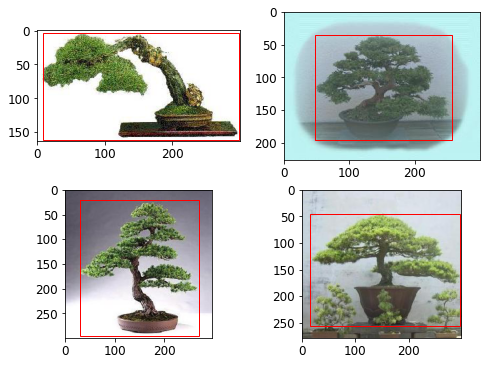

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8,6))
axs = axs.flatten()

for i in range(4):
  ximg   = Image.open(img_samples[i])
  img_id = img_samples[i].split('/')[-1].replace('.jpg', '').replace('image_', '')
  print(f'Image shape: {np.array(ximg).shape}')
  axs[i].imshow(ximg)

  ann_file     = os.path.join(ANN_PATH, mylabel_ann, 'annotation_' + img_id + '.mat')
  (y, h, x, w) = loadmat(ann_file)['box_coord'][0]

  rect = patches.Rectangle( (x, y), w-x, h-y, linewidth=1, edgecolor='r', facecolor='none')  
  axs[i].add_patch(rect)

plt.show()

Write image+annottion infor to CSV file

In [ ]:
print(f'Number of samples: {len(img_samples)}')

Number of samples: 128


In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/object_detection
!pwd

/content/gdrive/My Drive/Colab Notebooks/object_detection
/content/gdrive/My Drive/Colab Notebooks/object_detection


In [ ]:
csv_file = 'data_' + mylabel_img + '.csv'
csv_file = os.path.join(PREP_DIR, csv_file)
print(csv_file)
if not os.path.exists( csv_file ):
  write_to_csv(img_samples, csv_file)

/content/gdrive/My Drive/Colab Notebooks/object_detection/data/prep/data_bonsai.csv


Read infor from CSV file

In [ ]:
df = pd.read_csv(csv_file)

In [ ]:
df.head()

,class,img_file,annotation_file,ID,shapes,height,width,x_start,x_end,y_start,y_end,targets
0,bonsai,image_0007.jpg,annotation_0007.mat,_0007,"(164, 300, 3)",164.0,300.0,8.0,298.0,4.0,161.0,"[0.027, 0.993, 0.024, 0.982]"
1,bonsai,image_0043.jpg,annotation_0043.mat,_0043,"(227, 300, 3)",227.0,300.0,48.0,257.0,35.0,196.0,"[0.16, 0.857, 0.154, 0.863]"
2,bonsai,image_0037.jpg,annotation_0037.mat,_0037,"(300, 297, 3)",300.0,297.0,31.0,270.0,21.0,296.0,"[0.104, 0.909, 0.07, 0.987]"
3,bonsai,image_0041.jpg,annotation_0041.mat,_0041,"(279, 300, 3)",279.0,300.0,14.0,297.0,45.0,256.0,"[0.047, 0.99, 0.161, 0.918]"
4,bonsai,image_0028.jpg,annotation_0028.mat,_0028,"(225, 300, 3)",225.0,300.0,52.0,256.0,34.0,201.0,"[0.173, 0.853, 0.151, 0.893]"


In [ ]:
df.dtypes

class               object
img_file            object
annotation_file     object
ID                  object
shapes              object
height             float64
width              float64
x_start            float64
x_end              float64
y_start            float64
y_end              float64
targets             object
dtype: object

In [ ]:
df['targets'] = df['targets'].str.strip('[]').str.split(',').apply(lambda x: [float(i) for i in x])

In [ ]:
targets   = np.array( [x for x in df.targets], dtype='float32')
filenames = np.array( [x for x in df.img_file] )

In [ ]:
print('targets.shape: ', targets.shape)
targets[:3]

targets.shape:  (128, 4)


array([[0.027, 0.993, 0.024, 0.982],
       [0.16 , 0.857, 0.154, 0.863],
       [0.104, 0.909, 0.07 , 0.987]], dtype=float32)

In [ ]:
print('filenames.shape: ', filenames.shape)
filenames[:3]

filenames.shape:  (128,)


array(['image_0007.jpg', 'image_0043.jpg', 'image_0037.jpg'], dtype='<U14')

In [ ]:
# Read images to X
X = []
for xfile in filenames:
  ximg = load_img( os.path.join(DATA_PATH, mylabel_img, xfile), target_size=(224, 224) ) # For the input-size of VGG16
  ximg = img_to_array(ximg)

  X.append(ximg)

In [ ]:
print('Class: ', mylabel_img)
print('Number of images: ', len(X))
print('Shape of a sample image: ', X[0].shape)

Class:  bonsai
Number of images:  128
Shape of a sample image:  (224, 224, 3)


In [ ]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(X, dtype='float32')

In [ ]:
data.shape

(128, 224, 224, 3)

In [ ]:
# save to npy file
npy_file = 'data_' + mylabel_img + '.npy'
npy_file = os.path.join(PREP_DIR, npy_file)
np.save(npy_file, data)

#4. Label: Faces

In [ ]:
mylabel_img = 'Faces'
mylabel_ann = 'Faces_2'

img_samples = glob.glob( os.path.join(DATA_PATH, mylabel_img, '*') )
print('Number of sample images: ', len(img_samples))
print(img_samples[:5])

ann_samples = glob.glob( os.path.join(ANN_PATH, mylabel_ann, '*') )
print('Number of sample annotations: ', len(ann_samples))
print(ann_samples[:5])

Number of sample images:  435
['/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/Faces/image_0005.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/Faces/image_0016.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/Faces/image_0006.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/Faces/image_0008.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/Faces/image_0013.jpg']
Number of sample annotations:  435
['/content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations/Faces_2/annotation_0389.mat', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations/Faces_2/annotation_0126.mat', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations/Faces_2/annotation_0182.mat', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations

Plot some samples

Image shape: (349, 528, 3)
Image shape: (313, 473, 3)
Image shape: (339, 513, 3)
Image shape: (367, 555, 3)


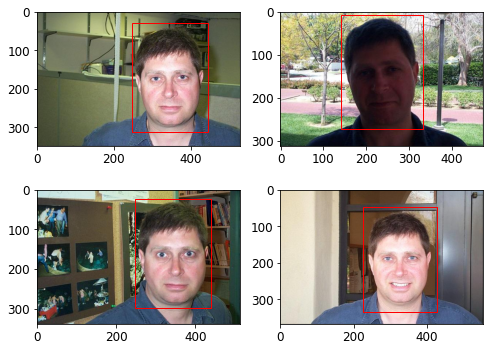

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8,6))
axs = axs.flatten()

for i in range(4):
  ximg   = Image.open(img_samples[i])
  img_id = img_samples[i].split('/')[-1].replace('.jpg', '').replace('image_', '')
  print(f'Image shape: {np.array(ximg).shape}')
  axs[i].imshow(ximg)

  ann_file     = os.path.join(ANN_PATH, mylabel_ann, 'annotation_' + img_id + '.mat')
  (y, h, x, w) = loadmat(ann_file)['box_coord'][0]

  rect = patches.Rectangle( (x, y), w-x, h-y, linewidth=1, edgecolor='r', facecolor='none')  
  axs[i].add_patch(rect)

plt.show()

Write image+annottion infor to CSV file

In [ ]:
print(f'Number of samples: {len(img_samples)}')

Number of samples: 435


In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/object_detection
!pwd

/content/gdrive/My Drive/Colab Notebooks/object_detection
/content/gdrive/My Drive/Colab Notebooks/object_detection


In [ ]:
csv_file = 'data_' + mylabel_img + '.csv'
csv_file = os.path.join(PREP_DIR, csv_file)
print(csv_file)
if not os.path.exists( csv_file ):
  write_to_csv(img_samples, csv_file)

/content/gdrive/My Drive/Colab Notebooks/object_detection/data/prep/data_Faces.csv


Read infor from CSV file

In [ ]:
df = pd.read_csv(csv_file)

In [ ]:
df.head()

,class,img_file,annotation_file,ID,shapes,height,width,x_start,x_end,y_start,y_end,targets
0,faces,image_0005.jpg,annotation_0005.mat,_0005,"(349, 528, 3)",349.0,528.0,246.0,446.0,30.0,312.0,"[0.466, 0.845, 0.086, 0.894]"
1,faces,image_0016.jpg,annotation_0016.mat,_0016,"(313, 473, 3)",313.0,473.0,141.0,331.0,8.0,272.0,"[0.298, 0.7, 0.026, 0.869]"
2,faces,image_0006.jpg,annotation_0006.mat,_0006,"(339, 513, 3)",339.0,513.0,248.0,440.0,22.0,298.0,"[0.483, 0.858, 0.065, 0.879]"
3,faces,image_0008.jpg,annotation_0008.mat,_0008,"(367, 555, 3)",367.0,555.0,227.0,429.0,47.0,333.0,"[0.409, 0.773, 0.128, 0.907]"
4,faces,image_0013.jpg,annotation_0013.mat,_0013,"(308, 466, 3)",308.0,466.0,213.0,397.0,23.0,278.0,"[0.457, 0.852, 0.075, 0.903]"


In [ ]:
df.dtypes

class               object
img_file            object
annotation_file     object
ID                  object
shapes              object
height             float64
width              float64
x_start            float64
x_end              float64
y_start            float64
y_end              float64
targets             object
dtype: object

In [ ]:
df['targets'] = df['targets'].str.strip('[]').str.split(',').apply(lambda x: [float(i) for i in x])

In [ ]:
targets   = np.array( [x for x in df.targets], dtype='float32')
filenames = np.array( [x for x in df.img_file] )

In [ ]:
print('targets.shape: ', targets.shape)
targets[:3]

targets.shape:  (435, 4)


array([[0.466, 0.845, 0.086, 0.894],
       [0.298, 0.7  , 0.026, 0.869],
       [0.483, 0.858, 0.065, 0.879]], dtype=float32)

In [ ]:
print('filenames.shape: ', filenames.shape)
filenames[:3]

filenames.shape:  (435,)


array(['image_0005.jpg', 'image_0016.jpg', 'image_0006.jpg'], dtype='<U14')

In [ ]:
# Read images to X
X = []
for xfile in filenames:
  ximg = load_img( os.path.join(DATA_PATH, mylabel_img, xfile), target_size=(224, 224) ) # For the input-size of VGG16
  ximg = img_to_array(ximg)

  X.append(ximg)

In [ ]:
print('Class: ', mylabel_img)
print('Number of images: ', len(X))
print('Shape of a sample image: ', X[0].shape)

Class:  Faces
Number of images:  435
Shape of a sample image:  (224, 224, 3)


In [ ]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(X, dtype='float32')

In [ ]:
data.shape

(435, 224, 224, 3)

In [ ]:
# save to npy file
npy_file = 'data_' + mylabel_img + '.npy'
npy_file = os.path.join(PREP_DIR, npy_file)
np.save(npy_file, data)

In [ ]:
# kangaroo

#4. Label: Kangaroos

In [ ]:
mylabel_img = 'kangaroo'
mylabel_ann = 'kangaroo'

img_samples = glob.glob( os.path.join(DATA_PATH, mylabel_img, '*') )
print('Number of sample images: ', len(img_samples))
print(img_samples[:5])

ann_samples = glob.glob( os.path.join(ANN_PATH, mylabel_ann, '*') )
print('Number of sample annotations: ', len(ann_samples))
print(ann_samples[:5])

Number of sample images:  86
['/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/kangaroo/image_0018.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/kangaroo/image_0008.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/kangaroo/image_0019.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/kangaroo/image_0010.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/101_ObjectCategories/kangaroo/image_0005.jpg']
Number of sample annotations:  86
['/content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations/kangaroo/annotation_0082.mat', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations/kangaroo/annotation_0056.mat', '/content/gdrive/My Drive/Colab Notebooks/object_detection/data/Annotations/kangaroo/annotation_0036.mat', '/content/gdrive/My Drive/Colab Notebooks/object_detection/

Plot some samples

Image shape: (300, 239, 3)
Image shape: (300, 287, 3)
Image shape: (300, 221, 3)
Image shape: (300, 274, 3)


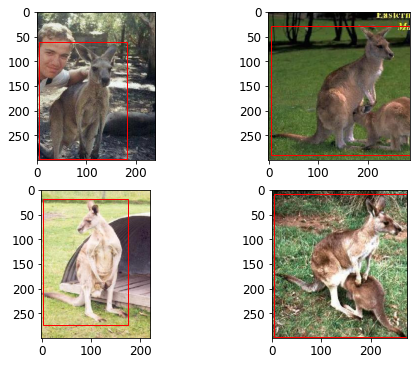

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8,6))
axs = axs.flatten()

for i in range(4):
  ximg   = Image.open(img_samples[i])
  img_id = img_samples[i].split('/')[-1].replace('.jpg', '').replace('image_', '')
  print(f'Image shape: {np.array(ximg).shape}')
  axs[i].imshow(ximg)

  ann_file     = os.path.join(ANN_PATH, mylabel_ann, 'annotation_' + img_id + '.mat')
  (y, h, x, w) = loadmat(ann_file)['box_coord'][0]

  rect = patches.Rectangle( (x, y), w-x, h-y, linewidth=1, edgecolor='r', facecolor='none')  
  axs[i].add_patch(rect)

plt.show()

Write image+annottion infor to CSV file

In [ ]:
print(f'Number of samples: {len(img_samples)}')

Number of samples: 86


In [ ]:
csv_file = 'data_' + mylabel_img + '.csv'
csv_file = os.path.join(PREP_DIR, csv_file)
print(csv_file)
if not os.path.exists( csv_file ):
  write_to_csv(img_samples, csv_file)

/content/gdrive/My Drive/Colab Notebooks/object_detection/data/prep/data_kangaroo.csv
87


Read infor from CSV file

In [ ]:
df = pd.read_csv(csv_file)

In [ ]:
df.head()

,class,img_file,annotation_file,ID,shapes,height,width,x_start,x_end,y_start,y_end,targets
0,kangaroo,image_0018.jpg,annotation_0018.mat,_0018,"(300, 239, 3)",300.0,239.0,3.0,182.0,61.0,298.0,"[0.013, 0.762, 0.203, 0.993]"
1,kangaroo,image_0008.jpg,annotation_0008.mat,_0008,"(300, 287, 3)",300.0,287.0,5.0,285.0,28.0,290.0,"[0.017, 0.993, 0.093, 0.967]"
2,kangaroo,image_0019.jpg,annotation_0019.mat,_0019,"(300, 221, 3)",300.0,221.0,2.0,176.0,18.0,273.0,"[0.009, 0.796, 0.06, 0.91]"
3,kangaroo,image_0010.jpg,annotation_0010.mat,_0010,"(300, 274, 3)",300.0,274.0,5.0,273.0,8.0,297.0,"[0.018, 0.996, 0.027, 0.99]"
4,kangaroo,image_0005.jpg,annotation_0005.mat,_0005,"(300, 276, 3)",300.0,276.0,24.0,238.0,65.0,254.0,"[0.087, 0.862, 0.217, 0.847]"


In [ ]:
df.dtypes

class               object
img_file            object
annotation_file     object
ID                  object
shapes              object
height             float64
width              float64
x_start            float64
x_end              float64
y_start            float64
y_end              float64
targets             object
dtype: object

In [ ]:
df['targets'] = df['targets'].str.strip('[]').str.split(',').apply(lambda x: [float(i) for i in x])

In [ ]:
targets   = np.array( [x for x in df.targets], dtype='float32')
filenames = np.array( [x for x in df.img_file] )

In [ ]:
print('targets.shape: ', targets.shape)
targets[:3]

targets.shape:  (86, 4)


array([[0.013, 0.762, 0.203, 0.993],
       [0.017, 0.993, 0.093, 0.967],
       [0.009, 0.796, 0.06 , 0.91 ]], dtype=float32)

In [ ]:
print('filenames.shape: ', filenames.shape)
filenames[:3]

filenames.shape:  (86,)


array(['image_0018.jpg', 'image_0008.jpg', 'image_0019.jpg'], dtype='<U14')

In [ ]:
# Read images to X
X = []
for xfile in filenames:
  ximg = load_img( os.path.join(DATA_PATH, mylabel_img, xfile), target_size=(224, 224) ) # For the input-size of VGG16
  ximg = img_to_array(ximg)

  X.append(ximg)

In [ ]:
print('Class: ', mylabel_img)
print('Number of images: ', len(X))
print('Shape of a sample image: ', X[0].shape)

Class:  kangaroo
Number of images:  86
Shape of a sample image:  (224, 224, 3)


In [ ]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(X, dtype='float32')

In [ ]:
data.shape

(86, 224, 224, 3)

In [ ]:
# save to npy file
npy_file = 'data_' + mylabel_img + '.npy'
npy_file = os.path.join(PREP_DIR, npy_file)
np.save(npy_file, data)